In [10]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.stats import entropy

from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from sklearn.model_selection import KFold, GroupKFold

pd.set_option('display.max_columns', None)

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

Output Dir:  ./outputs/


In [3]:
def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

In [11]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)
train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: entropy(row.values+1e-5), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] > 0.875).astype(int)

agg_dicts = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'eeg_label_offset_seconds': ['min', 'max'],
    'patient_id': 'first',
    'total_votes': 'sum',
    'entropy': 'mean',
    'is_hard': 'mean'
}

for col in targets:
    agg_dicts[col] = 'sum'

train_all = train_csv.groupby(['eeg_id']).agg(agg_dicts).reset_index()

col_names = [
    'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 
    'patient_id', 'total_votes', 'entropy', 'is_hard'
    ] + targets

train_all.columns = ["eeg_id"] + col_names
train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)

train_all['target'] = train_all[targets].idxmax(axis=1)
train_all['target'] = train_all['target'].apply(lambda x: x.split('_')[0])
train_all['fold'] = -1

K_FOLDS = 5

gkf = GroupKFold(n_splits=K_FOLDS)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(train_all, groups=train_all['patient_id'])):
    train_all.loc[valid_idx, 'fold'] = fold

print("train_all: ", train_all.shape)
for fold in range(K_FOLDS):
    train_size = train_all[train_all['fold'] != fold].shape[0]
    valid_size = train_all[train_all['fold'] == fold].shape[0]
    print(f"Fold {fold}: Train Size: {train_size}, Valid Size: {valid_size}")

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all:  (17089, 18)
Fold 0: Train Size: 13671, Valid Size: 3418
Fold 1: Train Size: 13671, Valid Size: 3418
Fold 2: Train Size: 13671, Valid Size: 3418
Fold 3: Train Size: 13671, Valid Size: 3418
Fold 4: Train Size: 13672, Valid Size: 3417


,eeg_id,spectrogram_id,min,max,eeg_off_min,eeg_off_max,patient_id,total_votes,entropy,is_hard,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,789577333,0.0,16.0,0.0,16.0,20654,48,0.959970,1.0,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,other,4
1,582999,1552638400,0.0,38.0,0.0,38.0,20230,154,0.509536,0.0,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,lpd,2
2,642382,14960202,1008.0,1032.0,0.0,24.0,5955,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,other,4
3,751790,618728447,908.0,908.0,0.0,0.0,38549,1,0.000626,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,gpd,2
4,778705,52296320,0.0,0.0,0.0,0.0,40955,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,other,2
5,1629671,2036345030,0.0,160.0,0.0,160.0,37481,51,0.000626,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,seizure,1
6,1895581,128369999,1138.0,1138.0,0.0,0.0,47999,13,0.536357,0.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,other,3
7,2061593,320962633,1450.0,1450.0,0.0,0.0,23828,1,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,other,0
8,2078097,2074135650,3342.0,3342.0,0.0,0.0,61174,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,other,2
9,2366870,1232582129,0.0,30.0,0.0,30.0,23633,18,0.636992,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,other,0


<Axes: xlabel='target'>

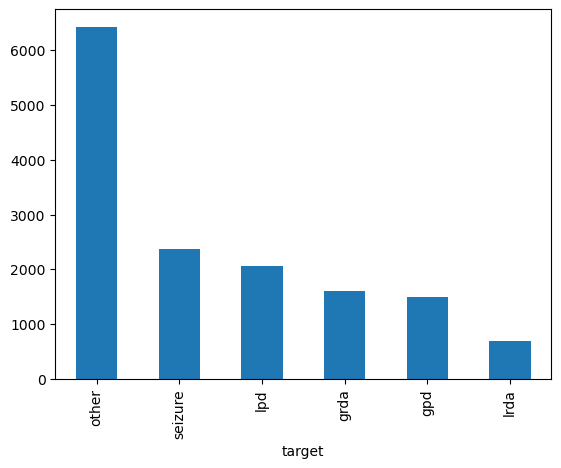

In [8]:
train_all[train_all['is_hard']==0]['target'].value_counts().plot(kind='bar')

In [ ]:
# randomly plot 5 target votes for is_hard=0 and is_hard=1  
fig, axes = plt.subplots(5, 2, figsize=(10, 15), sharex=True, sharey=True)

tmp = train_all[train_all['entropy']>0.01]
hard_samples = tmp[tmp['is_hard'] == 1].sample(5)
easy_samples = tmp[tmp['is_hard'] == 0].sample(5)

for i, ax in enumerate(axes[:, 0].flatten()):
    row = hard_samples.iloc[i]
    x = np.arange(6)
    ax.plot(x, row[targets].T.values, 'o-')
    ax.set_title(f"Hard | {row['target']} | H(P)={row['entropy']:.4f}")

for i, ax in enumerate(axes[:, 1].flatten()):
    row = easy_samples.iloc[i]
    x = np.arange(6)
    ax.plot(x, row[targets].T.values, 'o-')
    ax.set_title(f"Easy | {row['target']} H(P)={row['entropy']:.4f}")

plt.tight_layout()
plt.show()

In [ ]:
train_all[(train_all['is_hard'] == 1)]['target'].value_counts() 

In [ ]:
# plot in 2x3 grid the histogram of entropy for each target
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
brain_actities = train_all['target'].unique()
for i, target in enumerate(brain_actities):
    ax = axs[i//3, i%3]
    _df = train_all[train_all['target'] == target]
    ax.hist(_df['entropy'], bins=50, log=True)
    ax.set_title(f"{target} | Mean={_df['entropy'].mean():.4f} | Mid={_df['entropy'].median():.4f}")
    ax.grid()
plt.show()

In [ ]:
# plot entropy distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
# plt.hist(train_csv['entropy'], bins=50, log=True)
axes[2].hist(train_csv['entropy'], bins=20, log=False, alpha=0.5, label='All', color='green', range=(0.1, 2))
axes[2].set_title('All')

axes[0].hist(train_all[train_all['target']=='Seizure']['entropy'], bins=50, log=True, alpha=0.5, label='Hard', color='blue')
axes[1].hist(train_csv[train_csv['is_hard']==0]['entropy'], bins=50, log=True, alpha=0.5, label='Easy', color='red')
axes[0].set_title('Hard')
axes[1].set_title('Easy')
for ax in axes:
    # ax.set_xlim(0, 2)
    ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
tmp = train_all[train_all['entropy']>0.01]['entropy'].values
tmp.shape

In [ ]:
# apply a gaussian mixture model to the entropy values to separate the easy and hard samples
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=242)
gmm.fit(tmp.reshape(-1, 1))

print("Means: ", gmm.means_)
print("Covariances: ", gmm.covariances_)
print("Weights: ", gmm.weights_)
print("Converged: ", gmm.converged_)


In [ ]:
# predict hard/easy labels using the gmm model
entropy_labels = gmm.predict(train_all['entropy'].values.reshape(-1, 1))
train_all['entropy_label'] = entropy_labels

In [ ]:
# visualize the separation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(train_all[entropy_labels==0]['entropy'], bins=50, log=False, alpha=0.5, label='Easy', color='red', range=(0.1, 2))
ax.hist(train_all[entropy_labels==1]['entropy'], bins=50, log=False, alpha=0.5, label='Hard', color='blue', range=(0.1, 2))
ax.grid()
ax.legend()
ax.set_xlim(0.1, 2)
plt.show()

In [ ]:
# plot the histogram of entropy values with the gaussian mixture model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(tmp, bins=50, log=False, alpha=0.5, label='All', color='green', weights=np.ones(tmp.shape[0])/tmp.shape[0])
x = np.linspace(0, 2, 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
ax.plot(x, pdf, label='GMM', color='red')
ax.grid()
ax.legend() 

In [ ]:
train_all[train_all['entropy']<0.65].shape #[targets].sample(1).T.plot(kind='line', legend=False, figsize=(6, 4))

In [ ]:
14704 / (14704 + 5059)

In [ ]:
oof_df = pd.read_csv("/home/shiyi/kaggle_hms/outputs/EEGSeq_DilatedResNet_Deep_oof_1.csv")
oof_df 

In [ ]:
from scipy.special import softmax

label_to_idx = {label: idx for idx, label in enumerate(targets)}

# tmp_focal_loss = pd.concat([
#     train_all[train_all['is_hard']==1].sample(5)[targets],
#     train_all[train_all['is_hard']==0].sample(5)[targets]
# ])
n_samples = 100
targets_pred = [f"{col.split('_')[0]}_pred" for col in targets]
tmp_focal_loss = oof_df.sample(n_samples)[['eeg_id'] + targets + targets_pred].reset_index(drop=True)
y_preds = softmax(tmp_focal_loss[targets_pred].values, axis=1)
tmp_focal_loss[targets_pred] = y_preds

display(tmp_focal_loss.head())

tmp_focal_loss['true_label'] = tmp_focal_loss[targets].idxmax(axis=1).map(label_to_idx)
true_labes_one_hot = np.eye(6)[tmp_focal_loss['true_label'].values]

# y_preds = softmax(np.random.standard_normal((len(tmp_focal_loss), len(targets))), axis=1)
# tmp_focal_loss[targets] = y_preds

tmp_focal_loss['entropy'] = tmp_focal_loss[targets_pred].apply(lambda row: entropy(row.values+1e-10), axis=1)
tmp_focal_loss['kl_loss'] = np.sum(rel_entr(tmp_focal_loss[targets].values, tmp_focal_loss[targets_pred].values), axis=1)
tmp_focal_loss['reg_kl_loss'] = tmp_focal_loss['kl_loss'] - 2*tmp_focal_loss['entropy']

tmp_focal_loss['pred_label'] = tmp_focal_loss[targets_pred].idxmax(axis=1).map({label: idx for idx, label in enumerate(targets_pred)})

gamma = 2
alpha_0 = 0.25
k = 2

# calc_alpha = lambda x: min(1, alpha_0+k*x)
tmp_focal_loss['alpha'] = tmp_focal_loss['entropy'].apply(lambda x: 0.25 if x<0.65 else 0.75)

pt = np.where(true_labes_one_hot==1, y_preds, 1-y_preds)
tmp_focal_loss[[f"{col}_pt" for col in targets]] = pt

focal_loss = -tmp_focal_loss['alpha'].values[:, np.newaxis] * (1 - pt)**gamma * np.log(pt)
tmp_focal_loss['focal_loss'] = np.sum(focal_loss*true_labes_one_hot, axis=1)

tmp_focal_loss['cross_entropy'] = (tmp_focal_loss[targets].values * np.log(tmp_focal_loss[targets_pred].values+1e-5)).sum(axis=1)

In [ ]:
print(tmp_focal_loss['focal_loss'].mean())
tmp_focal_loss

In [ ]:
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)][targets_pred].T.plot()
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)][targets].T.plot()
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)]
# tmp_focal_loss['kl_loss'].idxmin(axis=0)

In [ ]:
plt.scatter(tmp_focal_loss['kl_loss'], tmp_focal_loss['entropy'])
plt.ylabel('Entropy')
plt.xlabel('KL Divergence')
plt.show()

In [ ]:
train_csv['total_votes'].plot(kind='hist', bins=20, title='Total Votes Distribution', range=(0, 20))

In [ ]:
unique_targets = train_all['target'].unique()
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, tgt in zip(axes.flatten(), unique_targets):
    print(f"Target: {tgt}")
    tmp = train_all[train_all['target'] == tgt].copy()
    # plot hist of entropy
    ax.hist(tmp['average_entropy'], bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f"{tgt}")
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
train_hard = train_all[train_all['is_hard']==1]
print(train_hard.shape)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
unique_spec_id = train_all['spectrogram_id'].unique()
print("unique_spec_id: ", len(unique_spec_id))
train_all['fold'] = 5
for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
    train_all.loc[train_all['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

fold_counts = train_all['fold'].value_counts()

target_counts = train_all[train_all['fold'] == 0]['target'].value_counts()
target_counts = target_counts / target_counts.sum()

for fold in range(5):
    target_counts = train_all[train_all['fold'] != fold]['target'].value_counts()
    target_counts = target_counts / target_counts.sum()
    target_counts.plot(kind='bar')
    plt.show()
   

In [ ]:
df_sub['seizure_prob']==0

In [ ]:
tgt_list = targets.to_list()

# agg_dict = {
#         'spectrogram_id': 'first',
#         'spectrogram_label_offset_seconds': ['min', 'max'],
#         'patient_id': 'first',
#         'expert_consensus': 'first',
#         'is_hard': lambda x: x.sum() / x.count()
#     }

agg_dict = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'patient_id': 'first',
    'expert_consensus': ['first', 'count', 'nunique'],
    'entropy': 'mean',
    'is_hard': lambda x: x.sum() / x.count()
}

for tgt in tgt_list:
    agg_dict[tgt] = 'sum'
    
df_agg = train_csv.groupby(['eeg_id']).agg(agg_dict).reset_index()
df_agg.columns = ['eeg_id','spectrogram_id', 'min', 'max', 'patient_id', 'target', 'target_count', 'target_nunique','averge_entropy', 'is_hard_ratio'] + tgt_list

df_agg['total_votes'] = df_agg[tgt_list].sum(axis=1)
df_agg[tgt_list] = df_agg[tgt_list].apply(lambda x: x / x.sum(), axis=1)

In [ ]:
df_agg[(df_agg['target_count']>1)&(df_agg['target_nunique']>1)].sort_values('target_count', ascending=False).head(50)

In [ ]:
pd.set_option("display.max_rows", None)
df_on_eeg = train_csv[train_csv['eeg_id']==188361788].sort_values('total_votes').reset_index()
df_to_plot = df_on_eeg.groupby('expert_consensus').apply(lambda x: x.sample(1)).reset_index(drop=True)
df_to_plot #[['eeg_id', 'spectrogram_id', 'spectrogram_label_offset_seconds', 'expert_consensus', 'is_hard', 'entropy', 'total_votes'] + tgt_list ]

In [ ]:
df_on_eeg.groupby(targets.tolist()).agg({
    'spectrogram_id': 'count',
    'eeg_label_offset_seconds': ['min', 'max'],
    'spectrogram_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)]
    }).reset_index()

In [ ]:
targets

In [ ]:
df_on_eeg[targets].mean(axis=0), df_on_eeg['spectrogram_label_offset_seconds'].min(), df_on_eeg['spectrogram_label_offset_seconds'].max(), df_on_eeg['eeg_label_offset_seconds'].min(), df_on_eeg['eeg_label_offset_seconds'].max()

In [ ]:
EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}
EEF_FEAT_INDEX

In [ ]:
def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [ ]:
spectrogram_id = df_to_plot['spectrogram_id'].values[0]
print(spectrogram_id)

spec_parquet = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_spectrograms/{spectrogram_id}.parquet")
print(spec_parquet.shape)

for idx, row in df_to_plot.iterrows():
    start = row['spectrogram_label_offset_seconds']
    spec_part = spec_parquet[(spec_parquet['time'] >= start) & (spec_parquet['time'] <= start+600)]
    print(f"Offset: {start}; Expert Consensus: {row['expert_consensus']}")
    plot_spec(spec_part)
    print("=================================")

In [ ]:
eeg_id = df_to_plot['eeg_id'].values[0]
print(eeg_id)

ch_1, ch_2 = 'Fp1', 'T3' #'Fp1', 'C3' #'T3', 'O1' #

eeg_seq = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet")
print(eeg_seq.shape)

fig, axes = plt.subplots(len(df_to_plot), 1, figsize=(10, 2*len(df_to_plot)))
i = 0
for idx, row in df_to_plot.iterrows():
    start = row['eeg_label_offset_seconds']
    label = row['expert_consensus']
    eeg_series = eeg_seq.iloc[int(start*200):int(start*200+50*200), :].values
    x_diff = eeg_series[:,EEF_FEAT_INDEX[ch_1]] - eeg_series[:,EEF_FEAT_INDEX[ch_2]]
    axes[i].plot(x_diff[::5], label=label)
    axes[i].grid()
    axes[i].legend()
    i += 1
    # axes.set_title(f"eeg_id: {eeg_id} | {ch_1} - {ch_2}")

fig.tight_layout()
plt.show()

In [ ]:
(df_agg['is_hard_ratio'] > 0.4).sum()

In [ ]:
tmp = train_csv.groupby('eeg_id')['is_hard'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=False)
tmp[tmp<0.3]

#.plot(kind='hist', bins=50, log=True)

In [ ]:
tmp = train_csv[train_csv['eeg_id']==3397233035 ]

averge_votes = tmp[targets].sum() / tmp['total_votes'].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
tmp[tmp['is_hard'] == 1][targets_prob].T.plot(ax=ax, legend=False, color='red', ls='--')
tmp[tmp['is_hard'] == 0][targets_prob].T.plot(ax=ax, legend=False, color='blue', ls=":")
averge_votes.plot(ax=ax, color='black', lw=2)
ax.grid()
plt.show()

In [ ]:
tmp[targets].sum() / tmp['total_votes'].sum()

In [ ]:
train_csv[train_csv['is_hard'] == 1]['total_votes'].plot(kind='hist', bins=10, log=True)

In [ ]:
# plot in log scale
train_csv.groupby('eeg_id').size().plot(kind='hist', bins=50, log=True, title='Number of samples per eeg_id')

In [ ]:
train_csv.groupby('eeg_id')['total_votes'].mean().plot(kind='hist', bins=20, log=True, title='Mean total votes per eeg_id')